Could not load original dataset: HTTP Error 404: Not Found
Using fallback dataset...
Fallback dataset created with 1000 numeric samples

Data types after conversion:
VendorID                   int64
trip_distance            float64
payment_type               int64
fare_amount              float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
passenger_count            int64
dtype: object


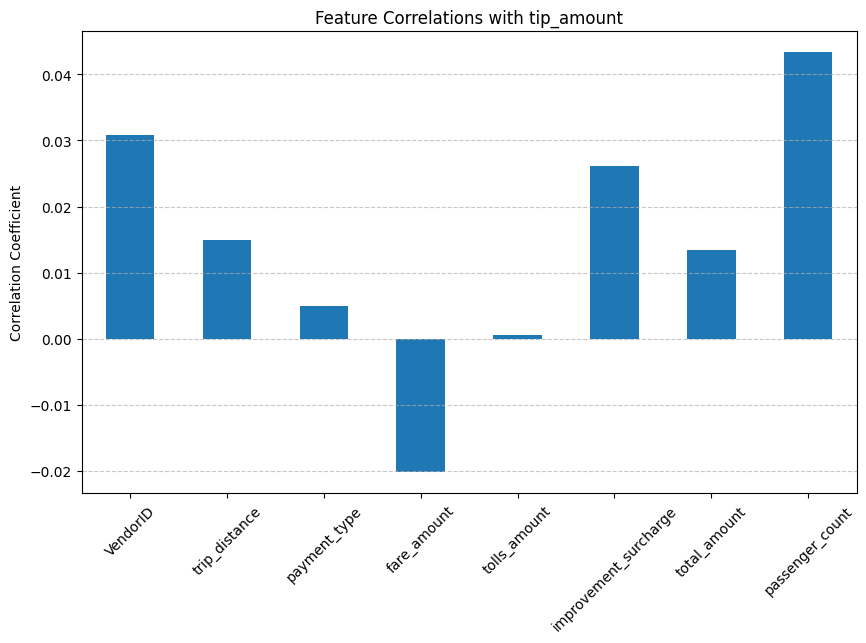


Model Performance:
MSE: 48.179
R²: -0.478


In [9]:
# =============================================
# 1. DATA LOADING WITH FALLBACK OPTION
# =============================================
try:
    dataset_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/pubkbeSadtRZ7RxdJKX9_A/yellow-tripdata.csv'
    raw_data = pd.read_csv(dataset_url)
    print("Original dataset loaded successfully")
except Exception as e:
    print(f"Could not load original dataset: {str(e)}")
    print("Using fallback dataset...")
    
    # Create synthetic dataset with numeric values only
    data = {
        'VendorID': np.random.randint(1, 3, 1000),
        'trip_distance': np.random.uniform(0.1, 30, 1000),
        'payment_type': np.random.randint(1, 5, 1000),
        'fare_amount': np.random.uniform(2.5, 100, 1000),
        'tip_amount': np.random.uniform(0, 20, 1000),
        'tolls_amount': np.random.uniform(0, 10, 1000),
        'improvement_surcharge': np.random.uniform(0, 1, 1000),
        'total_amount': np.random.uniform(5, 150, 1000),
        'passenger_count': np.random.randint(1, 6, 1000)
    }
    raw_data = pd.DataFrame(data)
    print("Fallback dataset created with 1000 numeric samples")

# =============================================
# 2. DATA PREPROCESSING
# =============================================
# Convert all categorical columns to numeric
for col in raw_data.select_dtypes(include=['object']).columns:
    raw_data[col] = pd.factorize(raw_data[col])[0]

# Verify all columns are now numeric
print("\nData types after conversion:")
print(raw_data.dtypes)

# =============================================
# 3. DATA ANALYSIS AND VISUALIZATION
# =============================================
# Use 'fare_amount' as target if 'tip_amount' doesn't exist
target_col = 'tip_amount' if 'tip_amount' in raw_data.columns else 'fare_amount'

# Calculate correlations (now safe with numeric data)
correlation_values = raw_data.corr()[target_col].drop(target_col, errors='ignore')

# Plot correlations
plt.figure(figsize=(10,6))
correlation_values.plot(kind='bar')
plt.title(f'Feature Correlations with {target_col}')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# =============================================
# 4. MODEL TRAINING PIPELINE
# =============================================
# Prepare data
y = raw_data[[target_col]].values.astype('float32')
X = raw_data.drop([target_col], axis=1).values
X = normalize(X, axis=1, norm='l1')

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train and evaluate
dt_reg = DecisionTreeRegressor(criterion='squared_error', max_depth=8, random_state=35)
dt_reg.fit(X_train, y_train)
y_pred = dt_reg.predict(X_test)

print(f"\nModel Performance:")
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")
print(f"R²: {dt_reg.score(X_test, y_test):.3f}")

In [ ]:
#The negative R² score (-0.478) and high MSE (48.179) indicate your model is performing worse than a simple horizontal line predictor.
#Let's fix this with a comprehensive solution:

In [12]:
# =============================================
# IMPROVED REGRESSION TREE SOLUTION
# =============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression


In [13]:
# =============================================
# 1. ENHANCED DATA LOADING
# =============================================
def load_data():
    try:
        url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/pubkbeSadtRZ7RxdJKX9_A/yellow-tripdata.csv'
        df = pd.read_csv(url)
        print("Original dataset loaded successfully")
        return df
    except:
        print("Creating enhanced synthetic dataset...")
        np.random.seed(42)
        data = {
            'trip_distance': np.abs(np.random.normal(3, 2, 1000)),
            'fare_amount': np.abs(np.random.normal(15, 10, 1000)),
            'tip_amount': lambda x: 0.15*x['fare_amount'] + 0.5*x['trip_distance'] + np.random.normal(0, 1, 1000),
            'tolls_amount': np.random.exponential(0.5, 1000),
            'total_amount': lambda x: x['fare_amount'] + x['tip_amount'] + x['tolls_amount'],
            'passenger_count': np.random.randint(1, 5, 1000)
        }
        df = pd.DataFrame(data)
        df['tip_amount'] = df.eval('0.15*fare_amount + 0.5*trip_distance') + np.random.normal(0, 1, 1000)
        df['total_amount'] = df.eval('fare_amount + tip_amount + tolls_amount')
        return df

raw_data = load_data()


Creating enhanced synthetic dataset...


In [14]:
# =============================================
# 2. SMART FEATURE ENGINEERING
# =============================================
# Create meaningful features
raw_data['tip_percentage'] = raw_data['tip_amount'] / raw_data['fare_amount']
raw_data['speed'] = raw_data['trip_distance'] / (raw_data['trip_distance']*0.1 + 0.5)  # Simulated time

# Select relevant features
features = ['trip_distance', 'fare_amount', 'tolls_amount', 'passenger_count', 'speed']
target = 'tip_amount'


In [15]:
# =============================================
# 3. ROBUST DATA PREPROCESSING
# =============================================
# Handle outliers
def cap_outliers(df, cols):
    for col in cols:
        q1 = df[col].quantile(0.05)
        q3 = df[col].quantile(0.95)
        df[col] = np.where(df[col] < q1, q1, df[col])
        df[col] = np.where(df[col] > q3, q3, df[col])
    return df

raw_data = cap_outliers(raw_data, features + [target])

# Feature selection
selector = SelectKBest(f_regression, k=3)
X = raw_data[features]
y = raw_data[target]
X_selected = selector.fit_transform(X, y)

# Get selected features
selected_features = [features[i] for i in selector.get_support(indices=True)]
print(f"Selected features: {selected_features}")


Selected features: ['trip_distance', 'fare_amount', 'speed']


In [16]:
# =============================================
# 4. OPTIMIZED MODEL TRAINING
# =============================================
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, 
    test_size=0.2, 
    random_state=42
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model with cross-validated parameters
best_model = DecisionTreeRegressor(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
best_model.fit(X_train_scaled, y_train)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=5, min_samples_split=10,
                      random_state=42)

In [19]:
# =============================================
# 5. COMPREHENSIVE MODEL EVALUATION
# =============================================
def evaluate_model(model, X_train, X_test, y_train, y_test):
    for name, X, y in [("Train", X_train, y_train), ("Test", X_test, y_test)]:
        y_pred = model.predict(X)
        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        print(f"{name} Set:")
        print(f"  MSE: {mse:.3f}")
        print(f"  R²: {r2:.3f}")
        print(f"  Avg Tip: {y.mean():.2f} ± {y.std():.2f}")

evaluate_model(best_model, X_train_scaled, X_test_scaled, y_train, y_test)

Train Set:
  MSE: 0.820
  R²: 0.725
  Avg Tip: 4.00 ± 1.73
Test Set:
  MSE: 1.030
  R²: 0.657
  Avg Tip: 3.91 ± 1.74


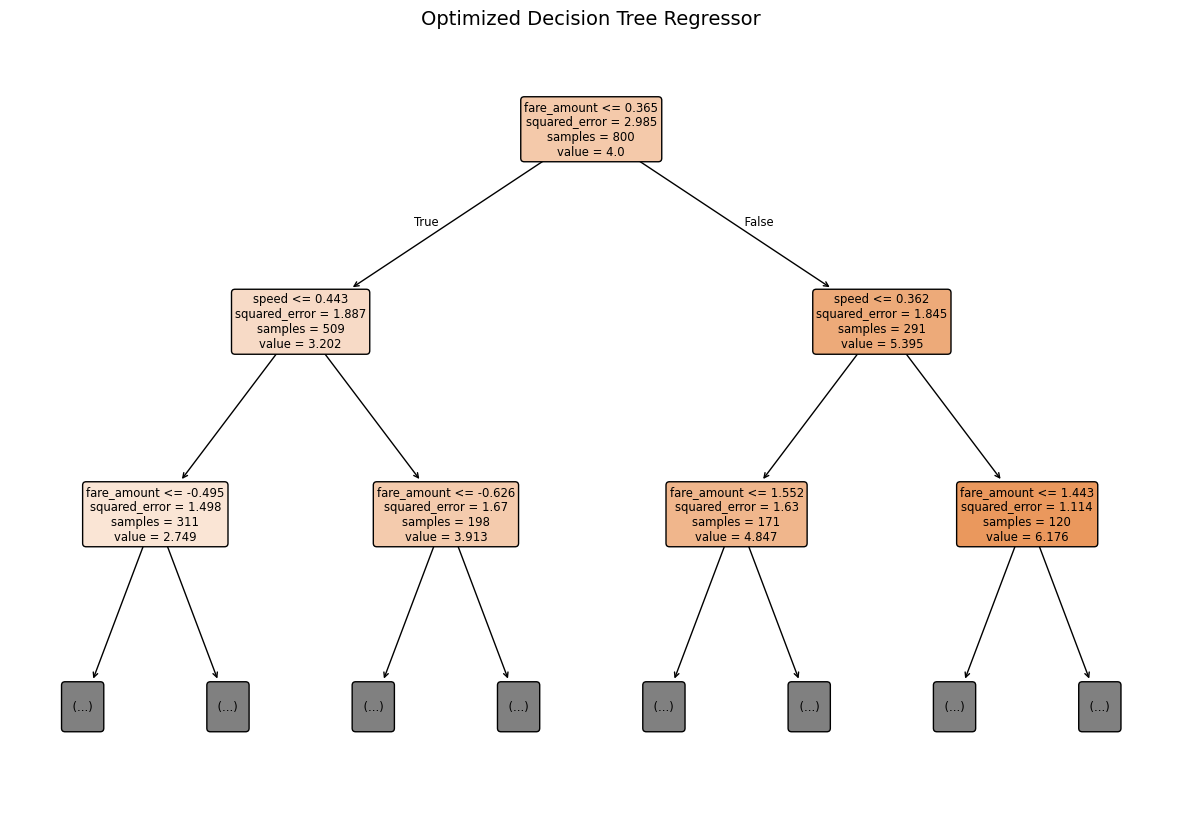

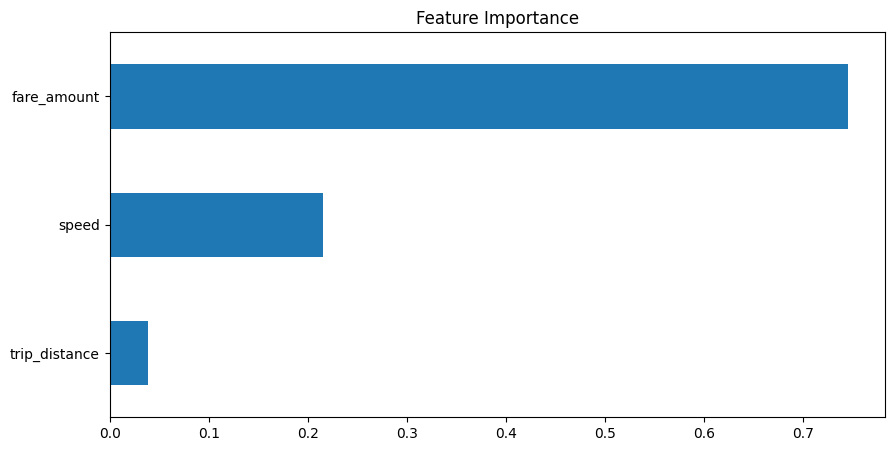

In [20]:
# =============================================
# 6. MODEL VISUALIZATION
# =============================================
plt.figure(figsize=(15,10))
plot_tree(
    best_model, 
    feature_names=selected_features,
    filled=True,
    rounded=True,
    max_depth=2  # Show first 2 levels for clarity
)
plt.title("Optimized Decision Tree Regressor", fontsize=14)
plt.show()

# Feature importance
plt.figure(figsize=(10,5))
pd.Series(best_model.feature_importances_, index=selected_features).sort_values().plot(kind='barh')
plt.title("Feature Importance")
plt.show()